In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import skimage
import os
import scipy.misc
from skimage import data
from scipy import ndimage
from skimage.color import rgb2gray, gray2rgb, rgb2hsv
import os
import numpy as np
import bokeh
from bokeh.io import output_notebook, curdoc
from bokeh.plotting import ColumnDataSource
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import d3
import bokeh.models as bmo
import pandas as pd
import win32api
import scipy.special
import seaborn as sns

In [2]:
GLOBAL_WIDTH = 800
GLOBAL_HEIGHT = 600
output_notebook()
pd.set_option('mode.chained_assignment', None)
plt.rcParams["figure.figsize"] = (10,10)

Loading BokehJS ...

The Problem
---

The problem we are approaching is analyzing and quantifying the change in Mondrian’s art style particularly in how his work shifts from more realistic art to abstract art later in his career. 

Data Generation
---

The data we are using to analyze Mondrian’s art style will be paintings founded in the catalogue raisonné http://pietmondrian.rkdmonographs.nl/. We will go through every painting on the site and go to their page on RKD database at https://rkd.nl/en/ and scrape those pages for image links, title, date of creation and other metadata then put it into a Pandas DataFrame. Only after will be pull the images from the links into our local storage and store them under a file hierarchy of ObjectType -> Date -> Image File named with work's title where the Date will be the year closest to a multiple of 5 where 1893 will be under 1895 and 1892 will be under 1890 while ranges of dates such as 1890 - 1894 will become the average of 1892 then classified the same way as singular years. We will also keep track of names and add a [1] or [2] to indicate duplicate names 

Historical Context
---
This data is appropriate for our analysis as we are looking to quantify Mondrian’s style over time so having a large dataset with as many of his works as possible will be important in doing statistical analysis based on different quantifications that we can gather from his works. Furthermore, having the metadata is necessary as we are interested in witnessing the evolution of Mondrian’s art style so we can graph statistics by year on a timeline which will make changes more apparent. The title and dimensions of the work may also provide insight that has not been explore in studies we have read up on such as if certain keyword such as objects in the title’s can be identified in the image where the lack of identifiable matching objects may indicate more abstract works as well. The dimensions may also lead to indications of abstraction or at the very least an evolution is his work as the sample of works we have been exposed to show Mondrian shifting away from the landscape portraits in his early work to more vertical or uniform in height and width.

# Preliminary Cleaning of Dataset

In the original code for scrapping from the website, we must consider the missing data from our dataset for each column

In [3]:
df = pd.read_csv('metadata.csv')

In [4]:
print('Columns with missing values')
print(df.isnull().any(axis=0))
print('Number of missing values from each column')
print(df.isnull().sum())
print('Percentage of missing values from each column')
print(df.isnull().sum() * 100 / len(df))

Columns with missing values
Image Link     False
Dimensions      True
Shape          False
Date            True
Title           True
Artist         False
Object Type    False
dtype: bool
Number of missing values from each column
Image Link       0
Dimensions     257
Shape            0
Date            21
Title            1
Artist           0
Object Type      0
dtype: int64
Percentage of missing values from each column
Image Link      0.000000
Dimensions     18.124118
Shape           0.000000
Date            1.480959
Title           0.070522
Artist          0.000000
Object Type     0.000000
dtype: float64


### Date

- For the Date column, it will be used for sorting our images by object type and by year so when we download and sort images we run the dates through the 'date_process' function which extracts the year of a painting from string type data while giving the value 'Date Missing' to rows with missing dates. 

- We can see that we are not losing much data when omitting the missing date images so I believe it is better to remove it as without dates it seems pointless to include certain artwork in doing analysis of the evolution of Mondrian's style

### Title

- For the Title column, we are missing one value but when we download images we save the image under 'No Title' as the title is not essential for analysis of style so we do not drop it

### Dimensions

- We are missing a large amount of data on dimensions however with regards to quality of the data we do not care for the actual dimensions of the picture instead we care about the digital resolution so we disregard this column

In [7]:
def grab_stats(image):
    try:
        if len(image.shape) == 2:
            image = gray2rgb(image)
        hsv_img = rgb2hsv(image)
        saturation_img = hsv_img[:,:, 1]
        value_img = hsv_img[:, :, 2]
        hue_img = hsv_img[:, :, 0]
        pixelcount = image.shape[0] * image.shape[1]
        mean_saturation = np.mean(saturation_img, axis=(0,1))
        mean_brightness = np.mean(value_img)
        mean_hue = np.mean(hue_img, axis=(0,1))
        per_row_var = np.var(value_img, axis=1)
        per_row_avg = np.mean(per_row_var)
        resolution = '{0} x {1}'.format(image.shape[0], image.shape[1])
        unique_colors = np.unique(image.reshape(-1, image.shape[-1]), axis=0).shape[0]
        return mean_saturation, mean_brightness, per_row_var, per_row_avg, pixelcount, resolution, mean_hue, unique_colors
    except ValueError:
        return None
    
def edge_score_calculate(img):
    if len(img.shape) == 2:
        img = gray2rgb(img)
    hsv_img = rgb2hsv(img)
    value_img = hsv_img[:, :, 2]
    
    sobel_x = ndimage.sobel(value_img, axis=0, mode='constant')
    sobel_y = ndimage.sobel(value_img, axis=1, mode='constant')
    edge_image = np.hypot(sobel_x, sobel_y)
    edge_score = np.sum(edge_image)
    return edge_score

    

### Choosing the object types to analyze

In [6]:
df['Object Type'].unique()

array(['drawing', 'painting', 'book', 'watercolor (painting)',
       'oil sketch', 'print', 'ethnographic',
       'pulpit, decorative wall component', 'ceiling painting', 'collage',
       'graphic design (guide term)', 'postcard', 'unknown', 'triptych',
       'scale-model', 'sketchbook, drawing', 'case furniture', 'chair',
       'table', 'terracotta'], dtype=object)

For the paintings, the categories under it would be:

- oil sketch
- painting
- watercolor (painting)

For drawings, the categories under it would be:

- drawing
- sketchbook, drawing

In [5]:
painting_categories = ['oil sketch', 'painting', 'watercolor (painting)']
drawing_categories = ['drawing', 'sketchbook, drawing']

Here we get the statistics we want to display such as resolution or saturation

In [8]:
df_image_stats = pd.DataFrame(columns=['Mean Saturation', 'Mean Brightness','Mean Hue', 'Edge Score', 'Per Row Average Variance', 'Pixel Count','Image Directory','Date','Description', 'Resolution', 'Category','Object Type','Color Complexity'])

main_dir = 'images'
for obj_type in os.listdir(main_dir):
    if (obj_type in painting_categories) or (obj_type in drawing_categories):
        for year in os.listdir(main_dir+'\\'+obj_type):
            files = os.listdir(main_dir+'\\'+obj_type+'\\'+year)
            for file in files:
                directory_file =(main_dir+'\\'+obj_type+'\\'+year+'\\'+file)
                img = io.imread(directory_file)
                stats = grab_stats(img)
                if not stats==None:
                    if obj_type in painting_categories:
                        category = 'Painting'
                    else:
                        category = 'Drawing'
                    edge_score = edge_score_calculate(img)
                    directory = main_dir+'\\'+obj_type+'\\'+year+'\\'+file
                    description = 'Name : {0}, Year : {1}, Object Type: {2}'.format(file,year,obj_type)
                    df_image_stats = df_image_stats.append({'Mean Saturation':stats[0], 'Mean Brightness':stats[1], 'Mean Hue':stats[6], 'Edge Score':edge_score, 'Per Row Average Variance':stats[3], 'Pixel Count':stats[4],'Resolution':stats[5],
                                                            'Image Directory':directory,'Date':year,'Description':description,'Category':category,'Object Type':obj_type,'Color Complexity':stats[7]}, ignore_index = True)
            

Here I remove the entries with missing dates

In [9]:
df_image_stats = df_image_stats[df_image_stats['Date']!='Date Missing']
df_image_stats['Date'] = df_image_stats['Date'].astype(int)

In [10]:
pixelcount_table = df_image_stats['Pixel Count'].values

In [11]:
curdoc().theme = 'dark_minimal'

def make_plot(title, hist, edges):
    p = figure(title=title, tools='', width=GLOBAL_WIDTH, height=GLOBAL_HEIGHT)
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="navy", alpha=0.5)
    p.y_range.start = 0
    p.xaxis.axis_label = 'x'
    p.yaxis.axis_label = 'Pr(x)'
    p.grid.grid_line_color="white"
    return p

hist, edges = np.histogram(pixelcount_table, density=True, bins=100)

p = make_plot("Resolution", hist, edges)
output_file('Resolution Distribution.html')
show(p)

In [12]:
print("Mean :{0}".format(np.mean(pixelcount_table)))
print("Median :{0}".format(np.median(pixelcount_table)))
print("Standard Deviation :{0}".format(np.std(pixelcount_table)))
print("Max :{0}".format(np.max(pixelcount_table)))
print("Min :{0}".format(np.min(pixelcount_table)))

Mean :321376.49253731343
Median :317850.0
Standard Deviation :50327.169741092956
Max :422500
Min :150800


### Resolution threshold

After visual examination of some images below the 200,000 pixelcount threshold it showed signs of image blurring due to low resolution resulting in loss of detail so that would be our resolution threshold 

With this threshold, we lose about 1.06% of our dataset which I believe is a fair trade-off so that our research is not muddled by low resolution images

In [13]:
df_image_stats[df_image_stats['Pixel Count']<=200000].shape[0]*100 / df_image_stats.shape[0]

1.077943615257048

In [14]:
df_image_stats_resolution_cutoff = df_image_stats[df_image_stats['Pixel Count']>200000]

In [166]:
df_image_stats_resolution_cutoff.to_csv ('test_df', index = False, header=True)

### Grayscale vs RGB

For images that are grayscale we can just add a new column to our dataframe of image information by checking if the shape of the image has 1 or 3 channels.  
As we can see for the example I have chosen of a colored image, when it is read in the shape indicates the number of rows and columns of pixels then the array of length 3 represents the three color channels RGB  
while the grayscale image I have chosen when read in only contains one value to represent each pixel instead of an array indicating it is a grayscale image

In [15]:
colored_mondrian_painting = io.imread('images/drawing/1905/Study for the Winkel mill.jpeg')
grayscale_mondrian_painting = io.imread('images/drawing/1905/Fen near Saasveld.jpeg')

In [16]:
print(colored_mondrian_painting.shape)
print(grayscale_mondrian_painting.shape)

(650, 431, 3)
(434, 650)


For our study of Mondrian's work we will be omitting about 1% of his work due to low resolution while retaining both Grayscale and RGB images as we research hue and saturation which require color but grayscale images of Mondrian's work can also  
be applied to these explorations as they indicate a lack of color in his work

As we can see 89.1% of the dataset is RGB however losing 10.9% of our dataset does not seem wise in our evaluation of Mondrian due to the limited dataset

In [17]:
df_image_stats_resolution_cutoff['RGB or Grayscale'] =  df_image_stats_resolution_cutoff['Image Directory'].apply(lambda x: len(io.imread(x).shape) == 3)

df_image_stats_resolution_cutoff['RGB or Grayscale'].sum()/df_image_stats_resolution_cutoff.shape[0]

# EDA

In [18]:
numerical_col = ['Mean Saturation','Mean Brightness','Mean Hue','Edge Score','Per Row Average Variance','Color Complexity']

In [19]:
categorical_col = ['Date','Category','RGB or Grayscale']

- For the first part of EDA, I examined the distributions of  certain categories such as Year, Painting/Drawing and RGB/Grayscale.

- Most of Mondrian's work found is dated around 1900 while there are fewer of his newer works which may explain some of the skews in the rest of our EDA.

- We also see that we have more painting than drawings from our Mondrian art dataset and that most of the work is in RGB format

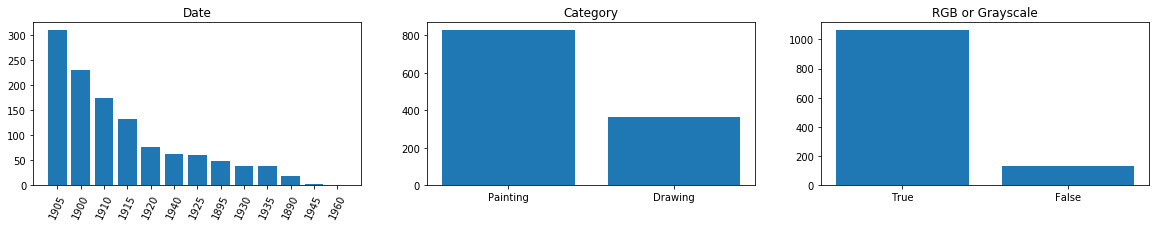

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_col), figsize=(20, 3))

graph_no = 0
axes[0].tick_params('x',labelrotation=65)
for i in categorical_col:
    axes[graph_no].set_title(i)
    axes[graph_no].bar(x = df_image_stats_resolution_cutoff[i].astype(str).value_counts().index.values, height = df_image_stats_resolution_cutoff[i].value_counts().values)
    graph_no += 1

In [21]:
numerical_df = df_image_stats_resolution_cutoff[numerical_col]
numerical_df['Color Complexity'] = numerical_df['Color Complexity'].apply(lambda x : x/(255**3))

max_edgescore = max(numerical_df['Edge Score'])
numerical_df['Edge Score'] =  numerical_df['Edge Score'].apply(lambda x : x/max_edgescore)

max_var = max(numerical_df['Per Row Average Variance'])
numerical_df['Per Row Average Variance'] =  numerical_df['Per Row Average Variance'].apply(lambda x : x/max_var)

Here we graph together the numerical variables we acquire from grabbing stats from our images however I do not see many clear relationships between categories.

One category with seemingly many positive relationships is the Color Complexity with other such as mean saturation and hue which is to be expected as with more colors
our image will be more saturated.

However other than this category there are not many strong relationships among other variables

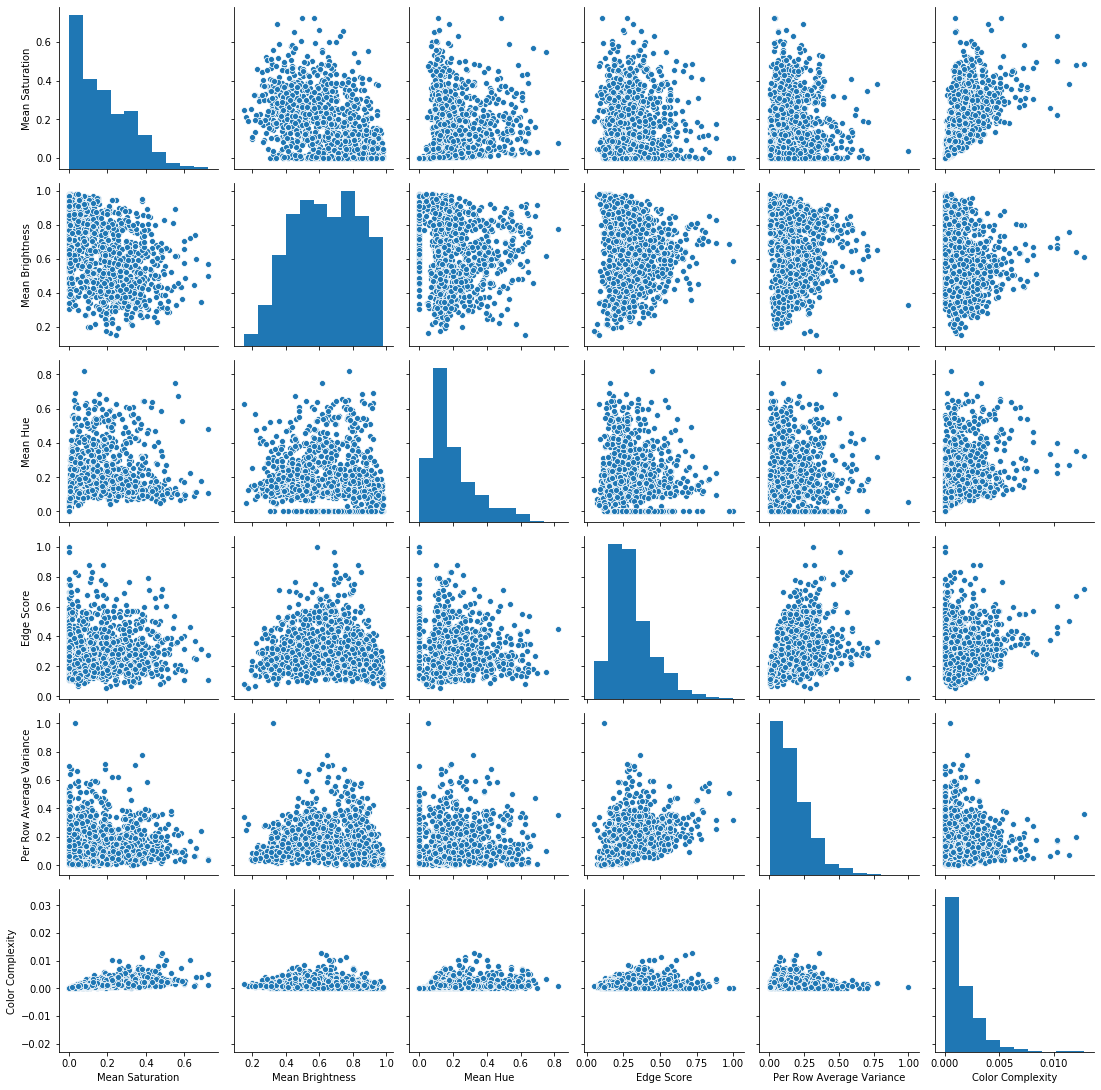

In [22]:
sns.pairplot(numerical_df)

Here we go through the numerical variables with the year the image was dated to.

Immediately we see much more correlation than the previous graphs such as the rise and fall of certain categories.

- For the mean brightness we see over time Mondrian's work gets much brighter which is in accordance with our studies showing his early works being of landscapes taking darker moods while his new works are much more colorful

- We also see the color variance decrease as Mondrian creates more uniform art without much color variance

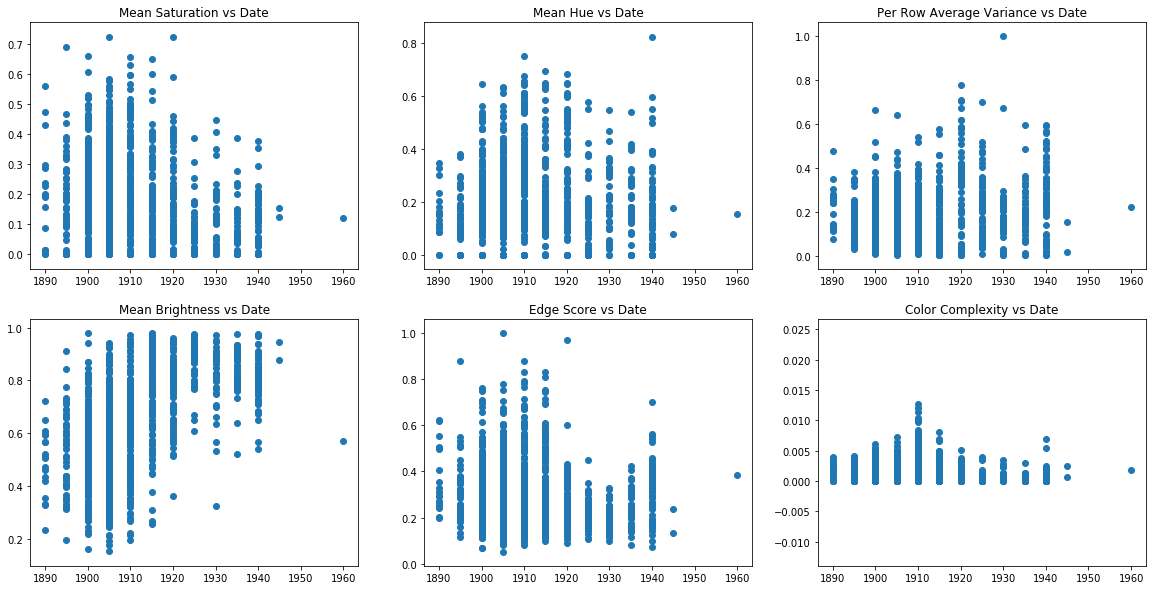

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=len(numerical_col)//2, figsize=(20, 10))

graph_no = 0

for i in range(len(numerical_col)//2):
    for j in range(2):
        axes[j,i].set_title(numerical_col[graph_no]+' vs Date')
        axes[j,i].scatter(x = df_image_stats_resolution_cutoff['Date'].values, y = numerical_df[numerical_col[graph_no]].values)
        graph_no += 1

### Artnome Mondrian Replication

Above I had already normalized these columns and I calculated the Complexity score based on the article's formula

Complexity score takes the edge score, per row average variance and color complexity and gets the average

Color complexity is simply the number of colors or unique RGB combinations in an image as we assume that more complex images have more colors or color gradiants

The per row average variance is the average variance of grayscale values per row and once again we assume that more complex images have more variance

The edge score is the calculation of the number of detected edges in the image, we assume that images with more lines are more complex as in Mondrian's later work the image is made up of a few lines so it has fewer edges

Each value was normalized seperately than the average was taken for the complexity score. These values are meant to capture the whole picture and based on certain assumptions tell us how complex the image is.

In [27]:
numerical_df['Complexity Score'] = (numerical_df['Edge Score'] + numerical_df['Per Row Average Variance'] + numerical_df['Color Complexity'])/3

In [88]:
numerical_df['Date'] = df_image_stats_resolution_cutoff['Date']
numerical_df['Image Directory'] = df_image_stats_resolution_cutoff['Image Directory']

In [94]:
dates = numerical_df['Date'].values
comp_score = numerical_df['Complexity Score'].values
img_dir = numerical_df['Image Directory'].values

In [111]:
output_file("complexity.html")

p = figure(x_range=(min(dates) - 5, max(dates) + 5), y_range=(0,1),title="Complexity Graph")
p.image_url(url = img_dir, x = dates, y = comp_score, w=1, h=0.01)
show(p)

### Critique

I believe that my recreation is similar to the graph shown on the Artnome blog, however if you inspect the first graph you see on the page it is a bad representation that misleads as the graph stops at the 1930s which leads us to believe the complexity does go down but we can see that around the early 1940s there is an increase in complexity and makes the outcome of the research much less successful. Furthermore the qualities they used for the image were overgeneralized and could lead to less accurate results

### CNN Analysis

One way to go beyond our Artnome replication is the use of CNNs to analyze our images. Using the model and Tensorflow we create feature vectors based on the actual images rather than statistics from the images to classify them with grouping. After creating the feature vectors we reduce and group them using UMAP. We see a shift from the left to right as his earlier works group together while around 1920 his work groups in an area further to the right

In [165]:
import os
import umap
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

### Note 

When working with keras and Tensorflow on my machine, I encountered issues with the packages not loading and found this as a fix for the Tensorflow backend

In [164]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

In [119]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras import backend as K
K.set_image_data_format('channels_first')

In [120]:
model = VGG16(weights='imagenet', include_top=False)

In [152]:
image_data = []
years = []
for obj_type in os.listdir(main_dir):
    if (obj_type in painting_categories) or (obj_type in drawing_categories):
        for year in os.listdir(main_dir+'\\'+obj_type):
            if year != 'Date Missing':
                files = os.listdir(main_dir+'\\'+obj_type+'\\'+year)
                for file in files:
                    years.append(int(year))
                    directory_file =(main_dir+'\\'+obj_type+'\\'+year+'\\'+file)
                    img = load_img(directory_file, target_size=(224, 224))
                    img = img_to_array(img)
                    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
                    img = preprocess_input(img)
                    vgg16_feature = model.predict(img)
                    vgg16_feature_np = np.array(vgg16_feature)
                    vgg16_feature_vector = vgg16_feature_np.flatten()
                    image_data.append(vgg16_feature_vector)

In [153]:
reducer = umap.UMAP(random_state=42)
reducer.fit(image_data)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=42,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=False)

In [154]:
embedding = reducer.transform(image_data)
assert(np.all(embedding == reducer.embedding_))

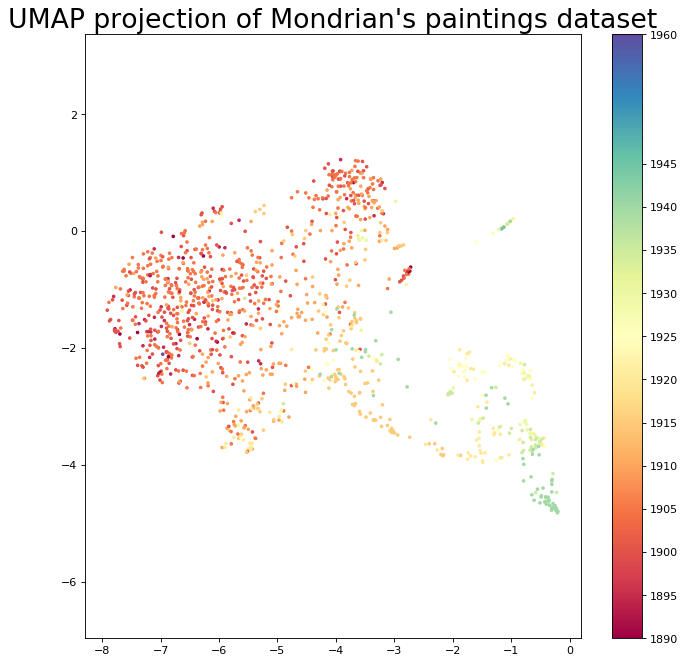

In [168]:
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(embedding[:, 0], embedding[:, 1], c=years, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar().set_ticks(list(set(years)))
plt.title('UMAP projection of Mondrian\'s paintings dataset', fontsize=24);
plt.savefig('umap_plot.png')

## Conclusion

I believe although general information can be gleaned from Artnome's research it is very surface level and many methods exist which would further the research. Works of art as we have discussed is extremely complicated and trying to sum up images with a few measures will not be sufficient in measuring complexity of an image. With neural nets and dimensional reductions we are able to work with many more features which take into account every part of the picture rather than focusing on the larger features of the image. 